<img src="https://vip.arizona.edu/images/logoviplab.png"/>

# <center> <font color='blue'>BE-BAT 485/585 -  Lab-8 </font> </center>
# <center> <font color='green'>EX-2 - Processingh Drone data </font> </center>
## In this exercise we will learn and work with drone data/image & calibration. then correct the data
### 1. Read a BSQ Landasat file (uncalibrated data) 
### 2. Convert DN to irradiance and correct surface reflectance
### 3. Save corrected bands as BSQ file

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import viplab_lib3 as vip

### Define two new user defined functiopn to read and process drone images 

In [3]:
#custom function to get the gain and offset
def get_linear_regression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return slope, intercept

In [4]:
def readDrone(fname,isRot):
    data= plt.imread(fname)
    if(isRot):
        # rotate data
        tmp=data[::-1]
        data=tmp[:,::-1]
    return data

### Collect info about the Calibration plate used to radiometrically calibrate the drone image 

### Calibration Plate Information from Manufacturer 

The MAPIR Calibration plate, like most plates, is used to calibrate multispectral images.
Calibration requires the plate has known response coefficients at each band<br>

<img src="./Data/Drone/P1_RGB_0002_090721_102608_G00_H109_A1160_R000_CAL.jpg" width=600></img>


* The Manufacterer provides the Calibration plate coefficients for each band<br>
* And these represent how much energy (%) the plate relfects back at each grey scale level and each band.
* The presence of different grey levels is needed to address saturation due to brightness of the sun (the brighter the betetr it is to use darker) <br>


<img src="./MAPIR_Plate_Coefficients.jpg" width=400></img>


In [5]:
# Calibration information for RED Band (this is provided by the manufacturer)
# This needs to be changed for the MAPIR data and DJI-P4-MS

# BLUE
REF_CP_BLUE_2=0.01999
REF_CP_BLUE_21=0.18548
REF_CP_BLUE_27=0.25098
REF_CP_BLUE_83=0.79629

#GREEN
REF_CP_GREEN_2=0.01955
REF_CP_GREEN_21=0.19733
REF_CP_GREEN_27=0.26648
REF_CP_GREEN_83=0.87157

# RED
REF_CP_RED_2  = 0.01925
REF_CP_RED_21 = 0.20229
REF_CP_RED_27 = 0.26674
REF_CP_RED_83 = 0.87689

# RED EDGE
REF_CP_RED_2=0.01945
REF_CP_RED_21=0.21728
REF_CP_RED_27=0.26662
REF_CP_RED_83=0.8753

# NIR
REF_CP_RED_2=0.02014
REF_CP_RED_21=0.23223
REF_CP_RED_27=0.27964
REF_CP_RED_83=0.86702


### Show image of calibration plate & Indicate the location of the Calibration targets

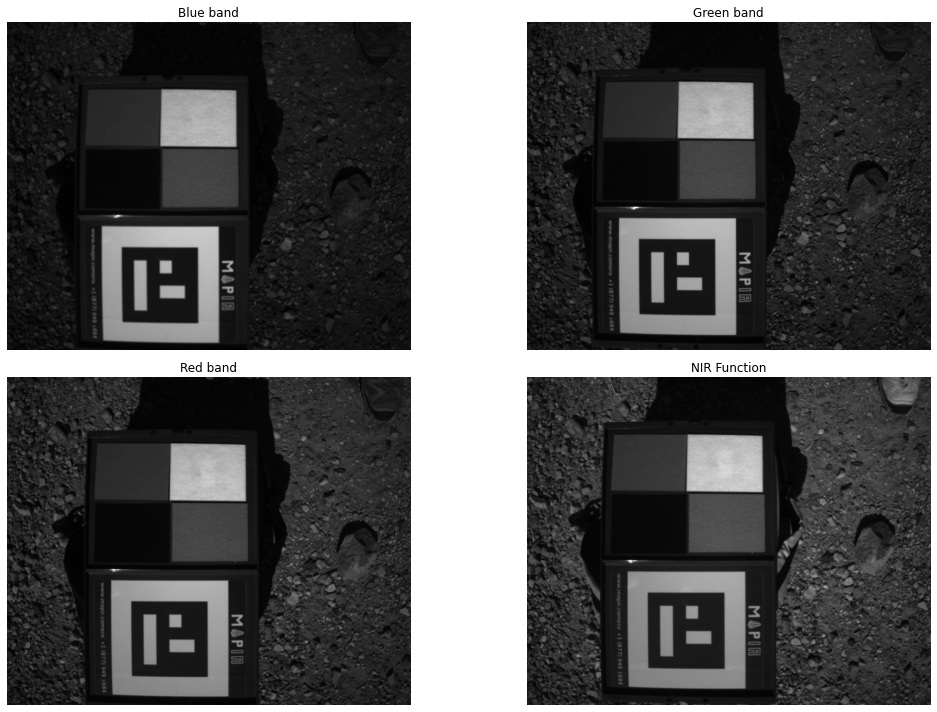

In [6]:
# Calibration Plate Processing:
isIMGRotated=True # Change to True if your image is inverted 

# Read calibration Plate for RED band
imageBLUE_PLATE=readDrone('./Data/Drone/P1_BLU_0002_090721_102608_G00_H109_A1160_R000_CAL.TIF',isIMGRotated)
imageGREEN_PLATE=readDrone('./Data/Drone/P1_GRE_0002_090721_102608_G00_H109_A1160_R000_CAL.TIF',isIMGRotated)
imageRED_PLATE=readDrone('./Data/Drone/P1_RED_0002_090721_102608_G00_H109_A1160_R000_CAL.TIF',isIMGRotated)
imageNIR_PLATE=readDrone('./Data/Drone/P1_NIR_0002_090721_102608_G00_H109_A1160_R000_CAL.TIF',isIMGRotated)
  
# Initialise the subplot function using number of rows and columns [2 x 2]

figure, axis = plt.subplots(2, 2,figsize=(16,10))

#TOP LEFT
axis[0, 0].imshow(imageBLUE_PLATE,cmap='gray')
axis[0, 0].set_title("Blue band")
axis[0,0].axis("off")

#TOP LEFT  
# For Cosine Function
axis[0, 1].imshow(imageGREEN_PLATE,cmap='gray')
axis[0, 1].set_title("Green band")
axis[0,1].axis("off")

#TOP LEFT
# For Tangent Function
axis[1, 0].imshow(imageRED_PLATE,cmap='gray')
axis[1, 0].set_title("Red band")
axis[1,0].axis("off")
#TOP LEFT
# For Tanh Function
axis[1, 1].imshow(imageNIR_PLATE,cmap='gray')
axis[1, 1].set_title("NIR Function")
axis[1,1].axis("off")

# Combine all
plt.tight_layout() 
plt.show()

### Did you notice the images above <font color="red">were not aligned properly</font> look at the bottom for example?
That is due to how the camera collects the data, as the different band sensors are slighlty not aligned with respect 
to the lens/optics. And we need to account for that.

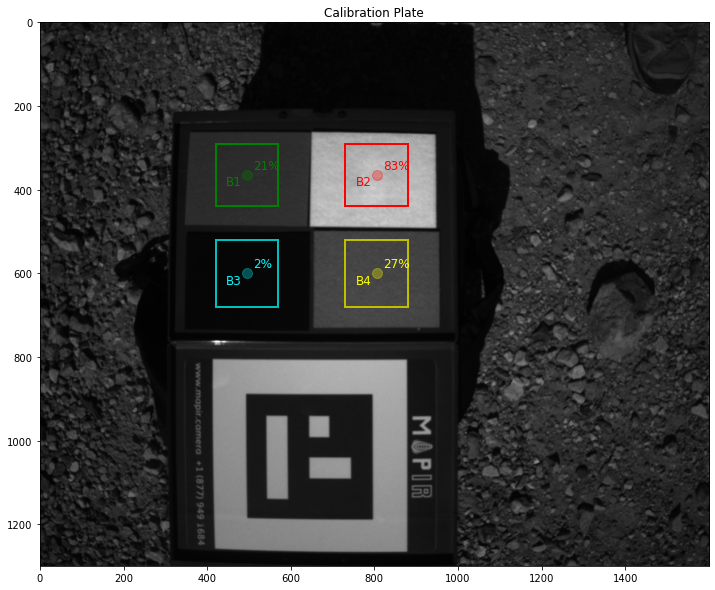

In [7]:
# Display Calibration Plate Image for RED
plt.figure(figsize=(20,10))

plt.title('Calibration Plate')
plt.imshow(imageRED_PLATE,cmap='gray')

#Set BOX 1 - GREEN
B1_ulx=420
B1_uly=290
B1_lrx=570
B1_lry=440

width=B1_lrx-B1_ulx
height=B1_lry-B1_uly
rectB1=patches.Rectangle((B1_ulx,B1_uly),width,height,linewidth=2,edgecolor='g',facecolor='none')

#Set BOX 2 - RED 
B2_ulx=730
B2_uly=290
B2_lrx=880
B2_lry=440

width=B2_lrx-B2_ulx
height=B2_lry-B2_uly
rectB2=patches.Rectangle((B2_ulx,B2_uly),width,height,linewidth=2,edgecolor='r',facecolor='none')

#Set BOX 3 - BLUE
B3_ulx=420
B3_uly=520
B3_lrx=570
B3_lry=680

width=B3_lrx-B3_ulx
height=B3_lry-B3_uly
rectB3=patches.Rectangle((B3_ulx,B3_uly),width,height,linewidth=2,edgecolor='c',facecolor='none')

#Set BOX 4 - YELLOW
B4_ulx= 730
B4_uly=520
B4_lrx= 880
B4_lry=680

width=B4_lrx-B4_ulx
height=B4_lry-B4_uly
rectB4=patches.Rectangle((B4_ulx,B4_uly),width,height,linewidth=2,edgecolor='y',facecolor='none')


# Add the rectangles to the Image display
plt.gca().add_patch(rectB1)
plt.gca().add_patch(rectB2)
plt.gca().add_patch(rectB3)
plt.gca().add_patch(rectB4)


# Label the boxes 
Objects_Label = ['21%','83%','2%','27%']
Objects_Label_B = ['B1','B2','B3','B4']

Objects_Color = ['green','red','cyan','yellow']

y_coords = [365,365,600,600]
x_coords = [495,805,495,805]
for i,type in enumerate(Objects_Label):
    plt.scatter(x_coords[i],y_coords[i], marker='o', color=Objects_Color[i],s=100,alpha=0.3)
    plt.text(x_coords[i]+15,y_coords[i]-15, Objects_Label[i], fontsize=12,color=Objects_Color[i])
    plt.text(x_coords[i]-50,y_coords[i]+25, Objects_Label_B[i], fontsize=12,color=Objects_Color[i])


### If your image shows up <font color="red">inverted</font> with respect to the outlined boxes
Then go back (previous cells in this code) and change the Invert FLAG The image should show up properly now

#### Average the info within the (white box) calibration target 

In [8]:
# Get Average DN number from Plate region [use the RED band for example]
DNavg_RED_83 = np.mean(imageRED_PLATE[B2_uly:B2_lry, B2_ulx:B2_lrx])
DNavg_RED_27 = np.mean(imageRED_PLATE[B4_uly:B4_lry, B4_ulx:B4_lrx])
DNavg_RED_21 = np.mean(imageRED_PLATE[B1_uly:B1_lry, B1_ulx:B1_lrx])
DNavg_RED_2 = np.mean(imageRED_PLATE[B3_uly:B3_lry, B3_ulx:B3_lrx])


#display values
print("CAL PLATE RED Avg at 83% : {:.{}f}".format(DNavg_RED_83, 2))
print("CAL PLATE RED Avg at 27% : {:.{}f}".format(DNavg_RED_27, 2))
print("CAL PLATE RED Avg at 21% : {:.{}f}".format(DNavg_RED_21, 2))
print("CAL PLATE RED Avg at 2% : {:.{}f}".format(DNavg_RED_2, 2))


CAL PLATE RED Avg at 83% : 45013.27
CAL PLATE RED Avg at 27% : 19554.18
CAL PLATE RED Avg at 21% : 14025.72
CAL PLATE RED Avg at 2% : 5516.49


### Now compute the calibration coefficient(s) from this white target 

Red band: gain= 2.12729298996654e-05 offset= -0.09755725126642027


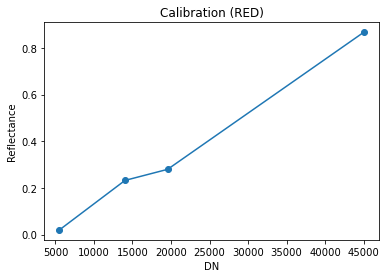

In [9]:
y=[REF_CP_RED_83, REF_CP_RED_27,REF_CP_RED_21, REF_CP_RED_2]
x=[DNavg_RED_83, DNavg_RED_27,DNavg_RED_21, DNavg_RED_2]

plt.figure()
plt.title('Calibration (RED)')
plt.xlabel('DN')
plt.ylabel('Reflectance')
plt.plot(x,y,marker='o')

# get gain and offset
gainRED, offsetRED = get_linear_regression(x,y)

print("Red band: gain=",gainRED, "offset=",offsetRED)

## Now apply these correction calibration coefficients to the actual image 

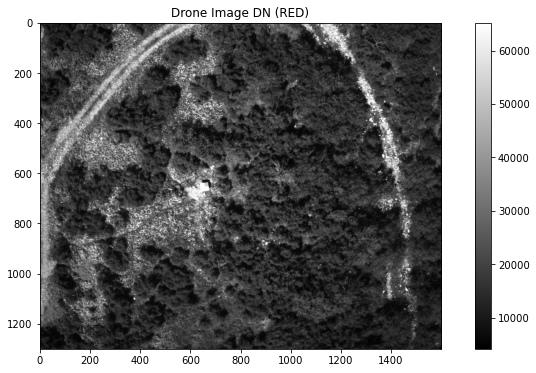

In [12]:
# Drone images processing:
# Read a DRONE image (RED band)
imageRED=readDrone('./Data/Drone/P1_RED_0069_090721_103316_G10_H089_A1230_R071.TIF',isIMGRotated)
plt.figure(figsize=(12,6))
plt.title('Drone Image DN (RED)')
plt.imshow(imageRED,cmap='gray')
plt.colorbar()


### Compute Surface reflection using those terms 

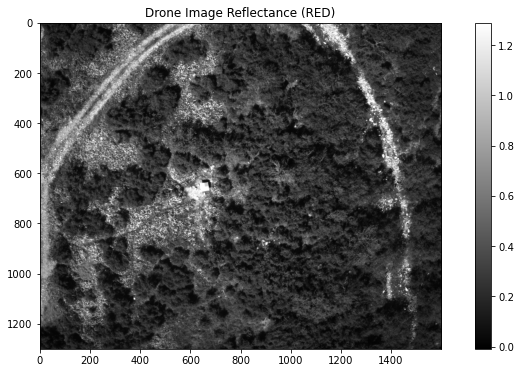

In [20]:
#Compute Reflectance for RED band
RED_Ref= imageRED * gainRED + offsetRED
plt.figure(figsize=(12,6))
plt.title('Drone Image Reflectance (RED)')
plt.imshow(RED_Ref,cmap='gray')
plt.colorbar()

### <font color ="blue">To DO </font>
#### 1: Now Process the calibration plate and drone images for the other bands
#### 2: Generate histogram of before and after
#### 3. Generate Transects & other statistical parameters 
#### 4: Generate False Color Images too (recall how that works and what it means)

In [19]:
## Code starts here 